In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
import seaborn as sns

from ONTraC.analysis.data import AnaData

In [2]:
from optparse import Values

options = Values()
options.meta_input = 'data/metadata_tbi10.csv'
options.decomposition_expression_input = 'data/celltypexgexp_tbi10.csv'
options.decomposition_cell_type_composition_input = 'data/spotxcelltype_tbi10.csv'
options.preprocessing_dir = 'visium_dlpfc/new_tbi10_preprocessing'
options.GNN_dir = 'visium_dlpfc/new_tbi10_GNN'
options.NTScore_dir = 'visium_dlpfc/new_tbi10_NTScore'
options.log = 'log/new_tbi10.log'
options.embedding_adjust = True
options.reverse = False  # Set it to False if you don't want reverse NT score
ana_data = AnaData(options)

In [3]:
# Manual ordering of the cell types for creation of the figures
sorted_cell_types = ['Cell_Type_9',
                     'Cell_Type_2',
                     'Cell_Type_1',
                     'Cell_Type_5',
                     'Cell_Type_0',
                     'Cell_Type_8',
                     'Cell_Type_6',
                     'Cell_Type_4',
                     'Cell_Type_3',
                     'Cell_Type_7']

## Figure 2a

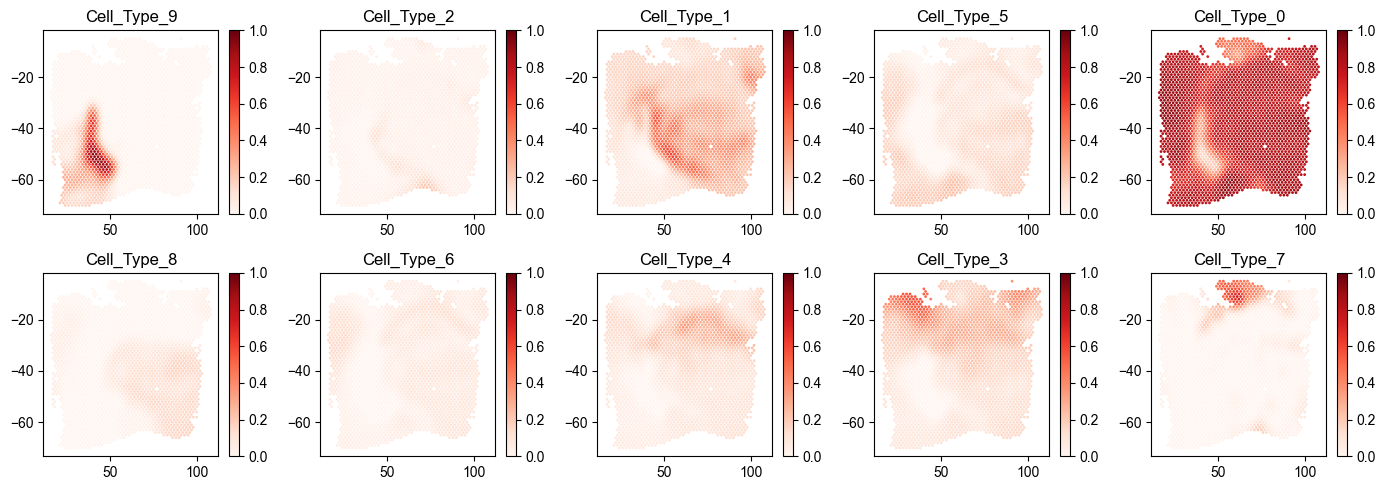

In [4]:
# Cell types in the incrementing ntscore order
samples = ana_data.cell_type_composition['sample'].unique().tolist()
cell_types = sorted_cell_types

M, N = len(samples), len(cell_types)
fig, axes = plt.subplots(2, 5, figsize=(14, 5))

for i, sample in enumerate(samples):
    sample_df = ana_data.cell_type_composition.loc[ana_data.cell_type_composition['sample'] == sample]
    for j, cell_type in enumerate(cell_types):
        ax_idx = i * N + j  # Flatten the 2D indices into a 1D index
        if ax_idx >= 20:  # Ensure we don't exceed the number of subplots
            break
        ax = axes.flatten()[ax_idx]  # Flatten the axes for easy access
        trans = Affine2D().rotate_deg(270) + ax.transData
        scatter = ax.scatter(sample_df['x'], sample_df['y'], c=sample_df[cell_type], cmap='Reds', vmin=0, vmax=1, s=1, transform=trans)
        # ax.set_aspect('equal', 'box')  # uncomment this line if you want set the x and y axis with same scaling
        # ax.set_xticks([])  # uncomment this line if you don't want to show x coordinates
        # ax.set_yticks([]) # uncomment this line if you don't want to show y coordinates
        plt.colorbar(scatter, ax=ax)
        ax.set_title(f"{cell_type}")

fig.tight_layout()
fig.savefig('figures/fig_2a_visium_cell_type_compostion.svg')

## Figure 2b

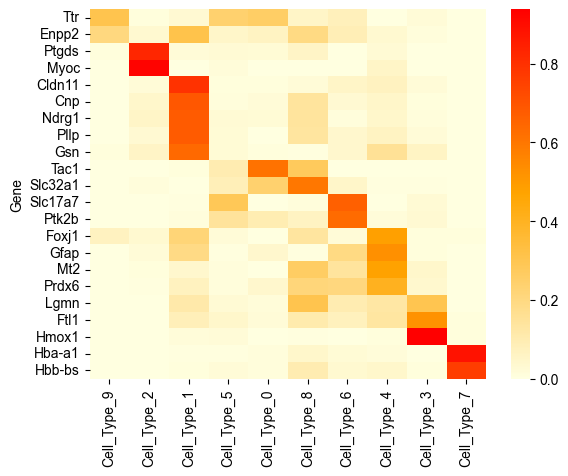

In [5]:
from matplotlib.colors import LinearSegmentedColormap

df = pd.read_csv("data/raw.csv")
df = df.drop("Unnamed: 11", axis=1)
df = df.rename(columns={'Unnamed: 0': 'Gene',
                       '1': 'Cell_Type_0',
                       '2': 'Cell_Type_1',
                       '3': 'Cell_Type_2',
                       '4': 'Cell_Type_3',
                       '5': 'Cell_Type_4',
                       '6': 'Cell_Type_5',
                       '7': 'Cell_Type_6',
                       '8': 'Cell_Type_7',
                       '9': 'Cell_Type_8',
                       '10': 'Cell_Type_9',})
df = df.set_index(df.columns[0])

# normalize by library size
df = df.truediv(df.sum())
# normalize by gene expression
df = df.truediv(df.sum(axis=1), axis=0)

# Manually reorder cell types and genes
df = df[sorted_cell_types]
new_row_order = ['Ttr','Enpp2','Ptgds','Myoc','Mgp','Cldn11','Cnp','Ndrg1','Pllp','Gsn','Tac1','Slc32a1','Slc17a7','Ptk2b','Foxj1',
                 'Gfap','Mt2','Prdx6','Lgmn','Ftl1','Hmox1','Hba-a1', 'Hbb-bs']
df = df.reindex(new_row_order)
df = df.drop('Mgp')

colors = ["lightyellow","orange", "red"]
cmap = LinearSegmentedColormap.from_list("yellow_red", colors)

heatmap = sns.heatmap(df, cmap = cmap)
fig = heatmap.get_figure()
fig.savefig("figures/fig_2b_gene_expression_heatmap.svg")

## Figure 2c

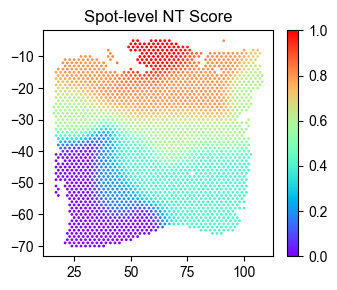

In [6]:
samples = ana_data.NT_score['sample'].unique().tolist()

N = len(samples)
fig, axes = plt.subplots(1, N, figsize=(3.5 * N, 3))
for i, sample in enumerate(samples):
    sample_df = ana_data.NT_score.loc[ana_data.NT_score['sample'] == sample]
    ax = axes[i] if N > 1 else axes
    NT_score = sample_df['Cell_NTScore'] if not ana_data.options.reverse else 1 - sample_df['Cell_NTScore']
    trans = Affine2D().rotate_deg(270) + ax.transData
    scatter = ax.scatter(sample_df['x'], sample_df['y'], c=NT_score, cmap='rainbow', vmin=0, vmax=1, s=1, transform=trans)
    # ax.set_aspect('equal', 'box')  # uncomment this line if you want set the x and y axis with same scaling
    # ax.set_xticks([])  # uncomment this line if you don't want to show x coordinates
    # ax.set_yticks([]) # uncomment this line if you don't want to show y coordinates
    plt.colorbar(scatter)
    ax.set_title("Spot-level NT Score")

fig.tight_layout()
fig.savefig('figures/fig_2c_spot_NT_score.svg')

## Figure 2d

In [7]:
# Load deconvolution matrix
deconv_df = pd.read_csv('data/spotxcelltype_tbi10.csv')

# Clean up the dataframe
data_df = deconv_df.join(ana_data.NT_score['Cell_NTScore'])
data_df.columns = [int(i)-1 if i != data_df.columns[-1] else i for i in data_df.columns]
data_df.columns = [f'Cell_Type_{i}' if i != data_df.columns[-1] else i for i in data_df.columns]
data_df.index.name = 'Cell_ID'
data_df = data_df.reset_index()

df_melted = data_df.melt(id_vars=['Cell_ID', 'Cell_NTScore'], var_name='cell_type', value_name='composition')

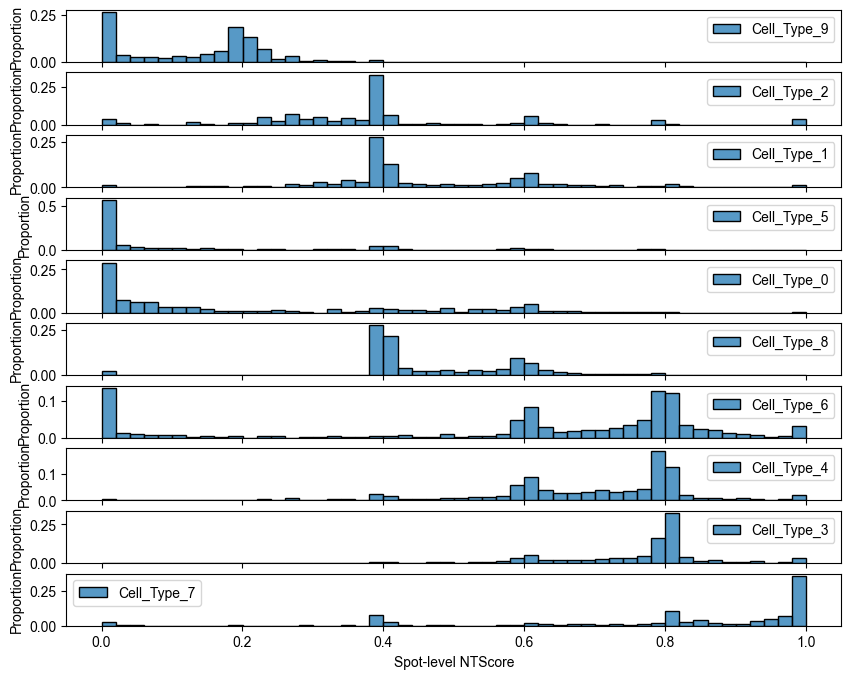

In [8]:
fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(10, 8))

# Plot the scatterplot
for ax, cell_type in zip(axes, sorted_cell_types):
    subset = df_melted[df_melted['cell_type'] == cell_type]
    subset.loc[:,'composition'] = subset['composition'].div(df_melted['composition'].sum())
    sns.histplot(subset, x='Cell_NTScore', stat='proportion', weights='composition', bins=50, ax=ax, label=cell_type)
    ax.legend()
    ax.set_xlabel("Spot-level NTScore")

plt.show()
fig.savefig("figures/Fig_2d_cell_type_distribution_over_NTScore.svg")

## Figure 2e

In [9]:
import scanpy as sc
from scipy.sparse import csr_matrix

# Load Visium dataset
adata = sc.read_visium("VLP4_C1_Visium")
adata.var_names_make_unique()

# Preprocessing
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Convert to dense matrix
dense_df = pd.DataFrame(adata.X.toarray())
dense_df.index = adata.obs.array_row.index
dense_df.columns = adata.var.index

/sc/arion/work/shins21/test-env/envs/stlearn/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/sc/arion/work/shins21/test-env/envs/stlearn/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [10]:
from scipy.stats import spearmanr

def spearman_correlation(gexpr, ntscore):
    correlations = {}
    for gene in gexpr.columns:
        correlation, _ = spearmanr(gexpr[gene], ntscore)
        correlations[gene] = correlation
    return correlations

# Calculate spearman correlation
correlations = spearman_correlation(dense_df, ana_data.NT_score['Cell_NTScore'])

# Convert to dataframe
corr_df = pd.DataFrame(list(correlations.items()), columns=['Gene', 'SpearmanCorrelation'])

# Prepare table for plotting
corr_df['SpearmanCorrelation'] = pd.to_numeric(corr_df['SpearmanCorrelation'], errors='coerce')
corr_df = corr_df.dropna(subset=['SpearmanCorrelation'])
corr_df = corr_df.sort_values(by='SpearmanCorrelation', ascending=True)
corr_df = corr_df.reset_index()
corr_df = corr_df.drop('index', axis=1)

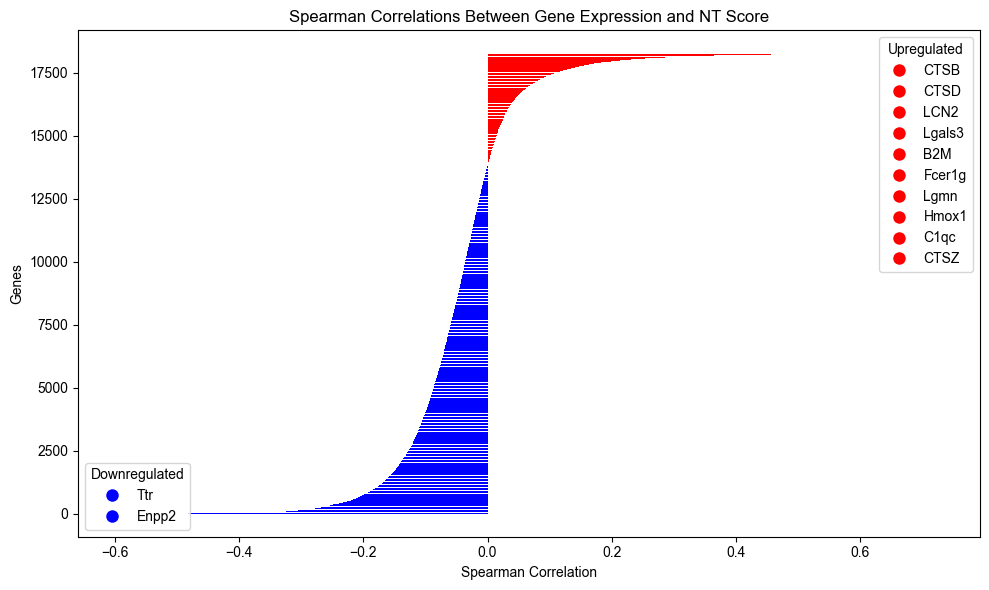

In [11]:
# Initialize the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the waterfall bars
bars = ax.barh(corr_df.index, corr_df['SpearmanCorrelation'], color=['red' if x > 0 else 'blue' for x in corr_df['SpearmanCorrelation']])

# Add labels and title
ax.set_xlabel('Spearman Correlation')
ax.set_ylabel('Genes')
ax.set_title('Spearman Correlations Between Gene Expression and NT Score')

# Manually selected genes for legends
upregulated_genes = ['CTSB', 'CTSD', 'LCN2', 'Lgals3', 'B2M', 'Fcer1g', 'Lgmn', 'Hmox1', 'C1qc', 'CTSZ']
downregulated_genes = ['Ttr', 'Enpp2']

# Add legends
up_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label=gene) for gene in upregulated_genes]
down_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label=gene) for gene in downregulated_genes]
up_legend = ax.legend(handles=up_handles, title='Upregulated', loc='upper right', bbox_to_anchor=(1, 1))
ax.add_artist(up_legend)
down_legend = ax.legend(handles=down_handles, title='Downregulated', loc='lower left', bbox_to_anchor=(0, 0))

plt.tight_layout()
plt.show()
fig.savefig("figures/fig_2e_spearman_correlation_gene_expression_NTScore.svg")